# Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedmohmedbalta/mitabovefivek")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mitabovefivek


# Import Needed Libraries

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

# Access Dataset Directories

In [8]:
root_path = os.path.join(path, "C")

# Data Loader & Transformation

In [9]:
class ColorCorrectionDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, limit = None):
        """
        Args:
            root_dir (str): Path to dataset root.
            split (str): Which split to use ("train" or "test").
            transform (callable, optional): Transform to apply to both images.
        """
        self.raw_dir = os.path.join(root_dir, split, "raw")
        self.processed_dir = os.path.join(root_dir, split, "target")

        # List files
        self.raw_files = sorted(os.listdir(self.raw_dir))
        self.processed_files = sorted(os.listdir(self.processed_dir))


        # Apply limit if provided
        if limit is not None:
            self.raw_files = self.raw_files[:limit]
            self.processed_files = self.processed_files[:limit]


        # Sanity check: equal number of files
        assert len(self.raw_files) == len(self.processed_files), \
            f"Mismatch! raw={len(self.raw_files)}, target={len(self.processed_files)}"

        self.transform = transform

    def __len__(self):
        return len(self.raw_files)

    def __getitem__(self, idx):
        raw_path = os.path.join(self.raw_dir, self.raw_files[idx])
        processed_path = os.path.join(self.processed_dir, self.processed_files[idx])

        raw_img = Image.open(raw_path).convert("RGB")
        processed_img = Image.open(processed_path).convert("RGB")

        if self.transform:
            raw_img = self.transform(raw_img)
            processed_img = self.transform(processed_img)

        return raw_img, processed_img



In [10]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


train_dataset = ColorCorrectionDataset(root_path, split="train", transform=transform, limit= 4750)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset  = ColorCorrectionDataset(root_path, split="test", transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 4750
Test size: 250


In [11]:
# Test a batch
raw_batch, processed_batch = next(iter(train_loader))
print(raw_batch.shape, processed_batch.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


# Show Sample Data

In [12]:
def show_pair(dataset, idx=0):
    """Show a raw vs. target pair from the dataset."""
    raw_img, target_img = dataset[idx]

    # If tensors -> convert back to numpy for plotting
    if hasattr(raw_img, "permute"):  
        raw_img = raw_img.permute(1, 2, 0).numpy()
        target_img = target_img.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(raw_img)
    axes[0].set_title("Raw Image")
    axes[0].axis("off")

    axes[1].imshow(target_img)
    axes[1].set_title("Target Image")
    axes[1].axis("off")

    plt.show()


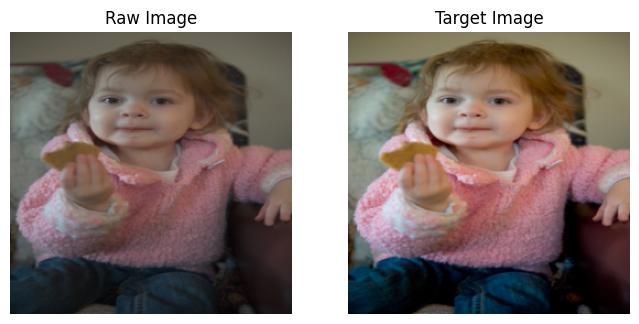

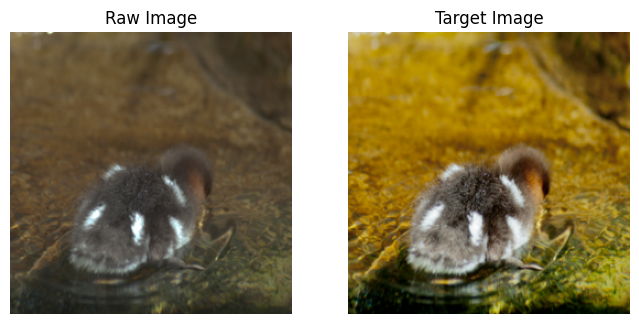

In [16]:
# Show training pair
show_pair(train_dataset, idx=1)

# Show a random training pair
show_pair(train_dataset, idx=random.randint(0, len(train_dataset)-1))

# Attention Block

In [ ]:
# ---------------- Attention Block ----------------
class AttentionBlock(nn.Module):
    def __init__(self, g_channels, x_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(g_channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(x_channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


# Attention UNet

In [17]:
# ---------------- Attention U-Net with Dropout ----------------
class AttentionUNet(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(AttentionUNet, self).__init__()

        def conv_block(in_channels, out_channels, use_dropout=False):
            layers = [
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if use_dropout:
                layers.append(nn.Dropout(dropout_p))
            return nn.Sequential(*layers)

        self.enc1 = conv_block(3, 64, use_dropout=True)
        self.enc2 = conv_block(64, 128, use_dropout=True)
        self.enc3 = conv_block(128, 256, use_dropout=True)
        self.enc4 = conv_block(256, 512, use_dropout=True)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024, use_dropout=True)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4 = AttentionBlock(g_channels=512, x_channels=512, inter_channels=256)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(g_channels=256, x_channels=256, inter_channels=128)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(g_channels=128, x_channels=128, inter_channels=64)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(g_channels=64, x_channels=64, inter_channels=32)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        e4 = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.out_conv(d1))


# Perceptual Loss Using VGG

In [18]:
# ---------------- Perceptual Loss ---------------- 
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()

    def forward(self, pred, target):
        pred_vgg = self.vgg(pred)
        target_vgg = self.vgg(target)
        return self.criterion(pred_vgg, target_vgg)

# Show Predictions

In [19]:
# ---------------- show predictions ----------------
def show_example(raw, pred, gt, epoch):
    raw   = raw.permute(1,2,0).cpu().numpy()
    pred  = pred.permute(1,2,0).detach().cpu().numpy()
    gt    = gt.permute(1,2,0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(raw); axs[0].set_title("RAW Input"); axs[0].axis("off")
    axs[1].imshow(pred); axs[1].set_title("Prediction"); axs[1].axis("off")
    axs[2].imshow(gt); axs[2].set_title("Ground Truth"); axs[2].axis("off")
    plt.suptitle(f"Epoch {epoch+1} Example")
    plt.show()

 # Early Stopping

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        patience: how many epochs to wait before stopping
        min_delta: minimum improvement to be considered
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # don’t stop
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(" Early stopping triggered!")
                return True  # stop training
            return False


# Training Setup

In [22]:
# ---------------- Training Setup ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model = AttentionUNet(dropout_p=0.2).to(device)

l1_loss = nn.L1Loss()
perc_loss = PerceptualLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

# Training Loop

Epoch [1/10] | Train Loss: 0.0936 | Val Loss: 0.0910


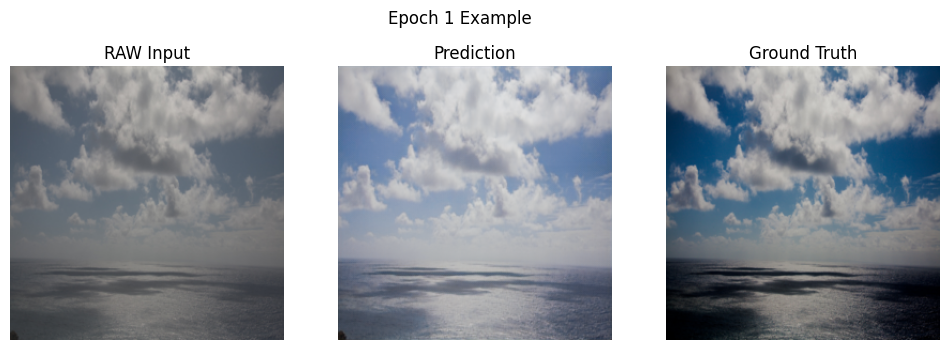

Epoch [2/10] | Train Loss: 0.0923 | Val Loss: 0.0915


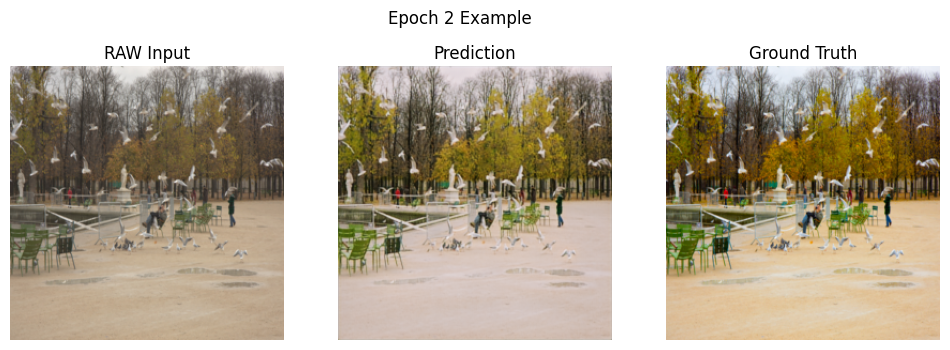

Epoch [3/10] | Train Loss: 0.0912 | Val Loss: 0.0890


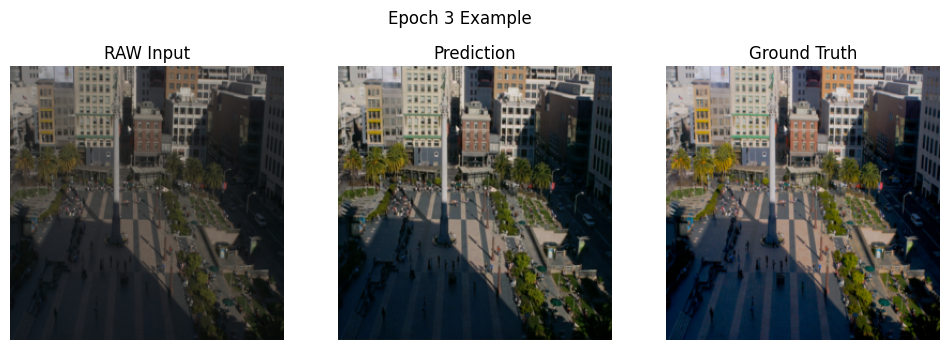

Epoch [4/10] | Train Loss: 0.0896 | Val Loss: 0.0887


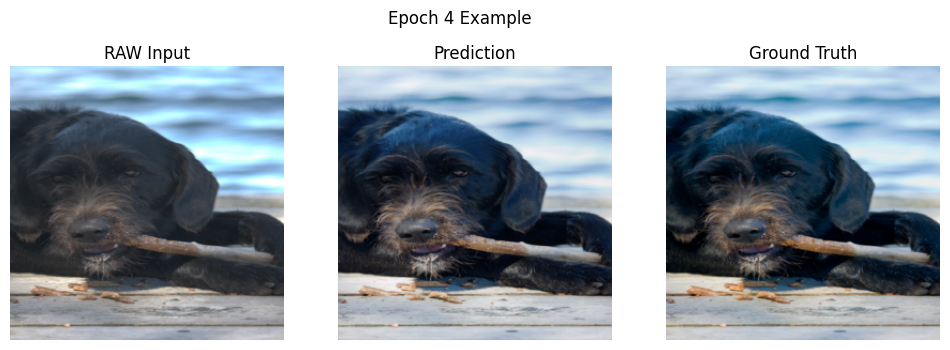

Epoch [5/10] | Train Loss: 0.0899 | Val Loss: 0.0877


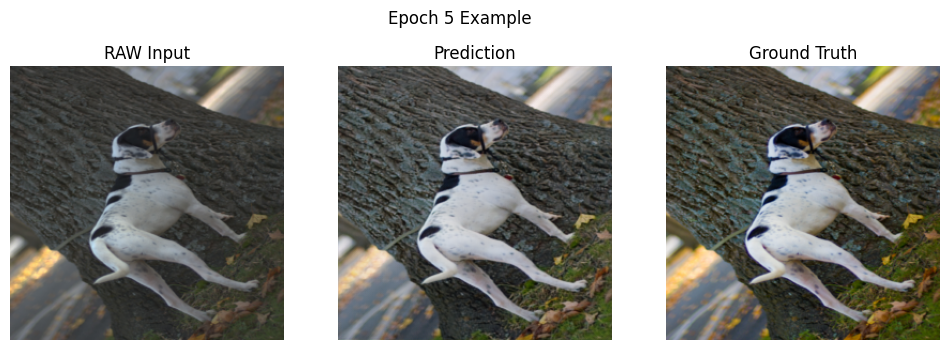

Epoch [6/10] | Train Loss: 0.0893 | Val Loss: 0.0929


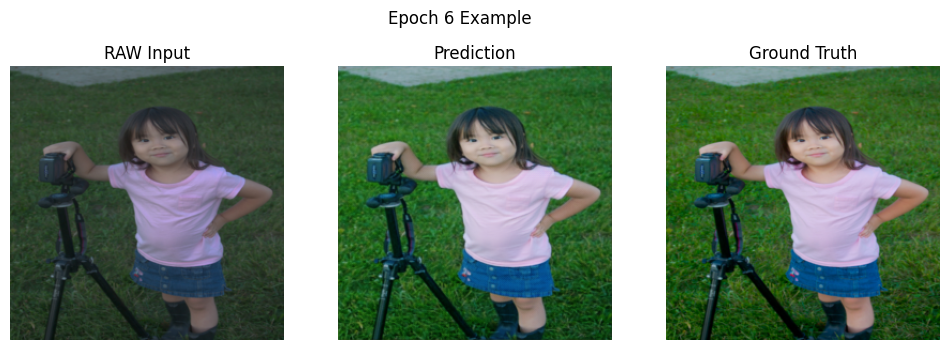

Epoch [7/10] | Train Loss: 0.0884 | Val Loss: 0.0899


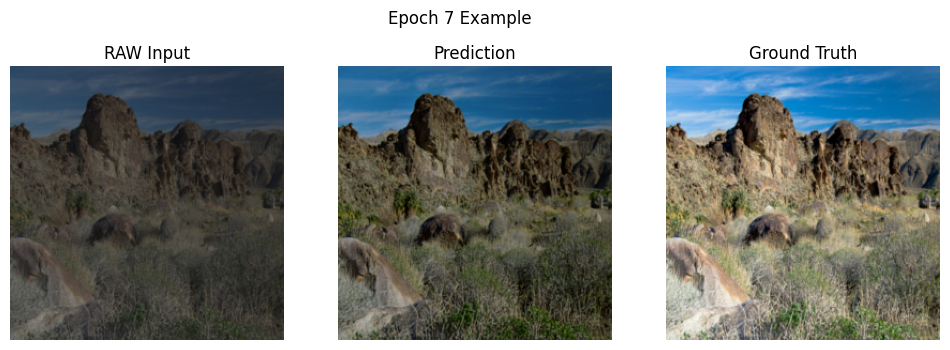

Epoch [8/10] | Train Loss: 0.0874 | Val Loss: 0.0870


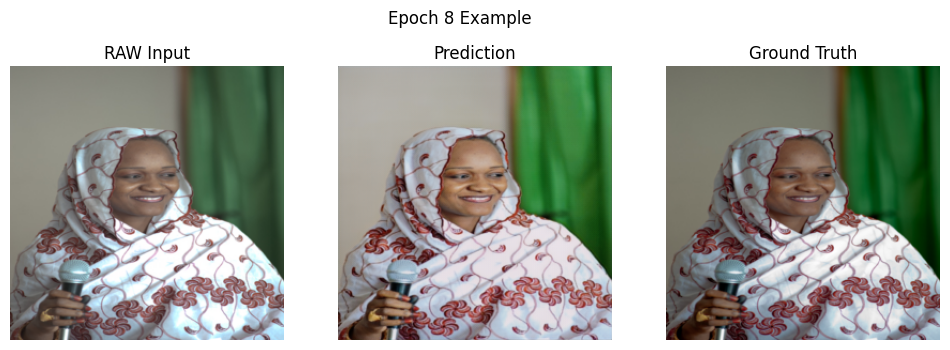

Epoch [9/10] | Train Loss: 0.0879 | Val Loss: 0.0880


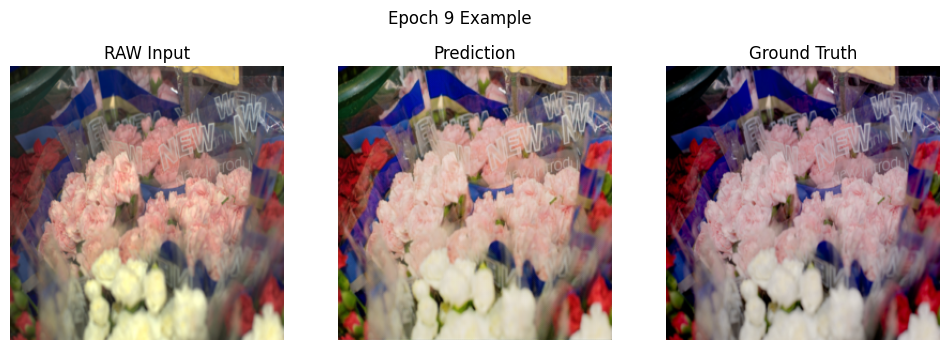

Epoch [10/10] | Train Loss: 0.0872 | Val Loss: 0.0907


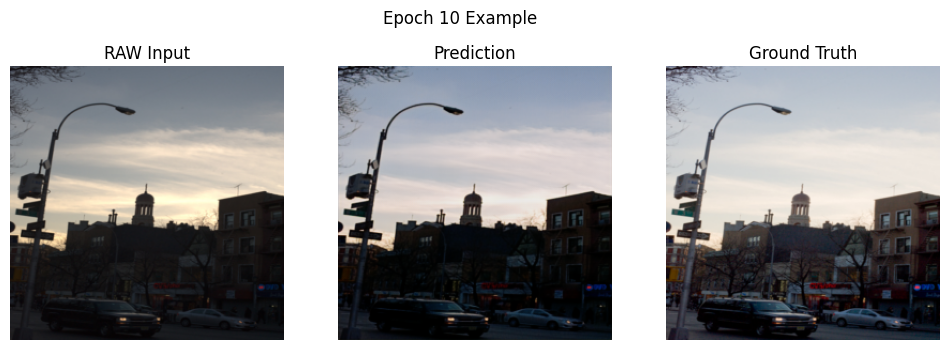

In [25]:
# ---------------- Training Loop ----------------
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for raw_img, target_img in train_loader:
        raw_img, target_img = raw_img.to(device), target_img.to(device)

        pred = model(raw_img)
        loss = l1_loss(pred, target_img) + 0.1 * perc_loss(pred, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for raw_img, target_img in test_loader:
            raw_img, target_img = raw_img.to(device), target_img.to(device)
            pred = model(raw_img)
            val_loss += (l1_loss(pred, target_img) + 0.1 * perc_loss(pred, target_img)).item()

    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if (epoch + 1) % 1  == 0:
        model.eval()
        with torch.no_grad():
            sample_raw, sample_target = random.choice(test_dataset)
            sample_raw = sample_raw.unsqueeze(0).to(device)
            sample_pred = model(sample_raw)

            show_example(
                sample_raw[0],
                sample_pred[0],
                sample_target,
                epoch
            )
            
    # --- Early Stopping ---
    if early_stopping(avg_val_loss):
        break

torch.save(model.state_dict(), "UNet_Attention.pth")

# Save Final Model 

In [ ]:
torch.save(model.state_dict(), "UNet_Attention.pth")